In [1]:
# Required installations and imports
!pip install torch torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.metrics import f1_score
from tqdm import tqdm
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_v

In [4]:
# Define the ConvolutionalVisionTransformer class with dropout
class ConvolutionalVisionTransformer(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(ConvolutionalVisionTransformer, self).__init__()
        self.vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
        in_features = self.vit.heads[0].in_features
        self.vit.heads = nn.Linear(in_features, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.vit(x)
        x = self.dropout(x)
        return x

In [5]:
# Advanced data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),  # New augmentation
    transforms.ColorJitter(),         # New augmentation
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [6]:
# Load datasets
train_dataset = datasets.ImageFolder(root='/content/real_vs_fake/real-vs-fake/train', transform=train_transform)
valid_dataset = datasets.ImageFolder(root='/content/real_vs_fake/real-vs-fake/valid', transform=valid_test_transform)
test_dataset = datasets.ImageFolder(root='/content/real_vs_fake/real-vs-fake/test', transform=valid_test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
# Instantiate the model with dropout
model = ConvolutionalVisionTransformer(num_classes=2, dropout_rate=0.5).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 193MB/s]


In [8]:
# Function for calculating F1 score
def calculate_f1_score(outputs, labels):
    preds = outputs.argmax(dim=1)
    return f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='weighted')

In [9]:
from google.colab import files


In [10]:
# Training and validation loop with progress bar, F1 score, enhanced early stopping, and auto-download after 10 epochs
best_val_loss = float('inf')
num_epochs = 15
warmup_epochs = 5
patience = 3
threshold = 0.01
num_bad_epochs = 0

for epoch in range(num_epochs):
    # Learning rate warm-up
    if epoch < warmup_epochs:
        lr_scale = min(1., float(epoch + 1) / warmup_epochs)
        for pg in optimizer.param_groups:
            pg['lr'] = lr_scale * 0.001

    # Training phase
    model.train()
    total_train_loss = 0
    total_steps = len(train_loader)
    train_progress_bar = tqdm(enumerate(train_loader), total=total_steps, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for i, (images, labels) in train_progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Average Training Loss: {average_train_loss:.4f}')

    # Validation phase
    model.eval()
    total_val_loss = 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_val_loss = total_val_loss / len(valid_loader)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}, F1 Score: {f1:.4f}')

    scheduler.step()

    # Early stopping check
    if avg_val_loss < best_val_loss - threshold:
        best_val_loss = avg_val_loss
        num_bad_epochs = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        num_bad_epochs += 1

    if num_bad_epochs >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

    # Save and download model after 10 epochs
    if epoch == 9:
        model_save_path = 'model_epoch_10.pth'
        torch.save(model.state_dict(), model_save_path)
        print("Model weights saved after 10 epochs")
        files.download(model_save_path)

# End of training loop


Epoch 1, Average Training Loss: 0.5864
Epoch 1, Validation Loss: 0.4298, F1 Score: 0.8066


Epoch 2, Average Training Loss: 0.5393
Epoch 2, Validation Loss: 0.4866, F1 Score: 0.7657


Epoch 3, Average Training Loss: 0.5195
Epoch 3, Validation Loss: 0.4134, F1 Score: 0.8168


Epoch 4, Average Training Loss: 0.5141
Epoch 4, Validation Loss: 0.4367, F1 Score: 0.8028


Epoch 5, Average Training Loss: 0.5051
Epoch 5, Validation Loss: 0.3870, F1 Score: 0.8251


Epoch 6, Average Training Loss: 0.4766
Epoch 6, Validation Loss: 0.4218, F1 Score: 0.7973


Epoch 7, Average Training Loss: 0.4535
Epoch 7, Validation Loss: 0.3335, F1 Score: 0.8601


Epoch 8, Average Training Loss: 0.3654
Epoch 8, Validation Loss: 0.2349, F1 Score: 0.9054


Epoch 9, Average Training Loss: 0.3361
Epoch 9, Validation Loss: 0.2104, F1 Score: 0.9180


Epoch 10, Average Training Loss: 0.3159
Epoch 10, Validation Loss: 0.1921, F1 Score: 0.9219
Model weights saved after 10 epochs


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 11, Average Training Loss: 0.3047
Epoch 11, Validation Loss: 0.1786, F1 Score: 0.9285


Epoch 12, Average Training Loss: 0.2948
Epoch 12, Validation Loss: 0.1694, F1 Score: 0.9325


Epoch 13, Average Training Loss: 0.2838
Epoch 13, Validation Loss: 0.1755, F1 Score: 0.9290


Epoch 14, Average Training Loss: 0.2737
Epoch 14, Validation Loss: 0.1542, F1 Score: 0.9378


Epoch 15, Average Training Loss: 0.2566
Epoch 15, Validation Loss: 0.1477, F1 Score: 0.9411


In [11]:
# Step 8: Save Model
torch.save(model.state_dict(), 'CNNViT_model.pth')

In [12]:



# Download the saved model file
files.download('CNNViT_model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
def calculate_test_accuracy(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Calculate test accuracy
test_accuracy = calculate_test_accuracy(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 94.14%


In [14]:
def print_actual_vs_predicted(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Print actual vs predicted for each image
    for i in range(len(all_true_labels)):
        actual = 'real' if all_true_labels[i] == 0 else 'fake'
        predicted = 'real' if all_predictions[i] == 0 else 'fake'
        print(f"Image {i + 1}: Actual - {actual}, Predicted - {predicted}")

# Execute the function
print_actual_vs_predicted(model, test_loader, device)


Streaming output truncated to the last 5000 lines.
Image 15001: Actual - fake, Predicted - fake
Image 15002: Actual - fake, Predicted - fake
Image 15003: Actual - fake, Predicted - fake
Image 15004: Actual - fake, Predicted - fake
Image 15005: Actual - fake, Predicted - fake
Image 15006: Actual - fake, Predicted - fake
Image 15007: Actual - fake, Predicted - fake
Image 15008: Actual - fake, Predicted - fake
Image 15009: Actual - fake, Predicted - fake
Image 15010: Actual - fake, Predicted - fake
Image 15011: Actual - fake, Predicted - fake
Image 15012: Actual - fake, Predicted - real
Image 15013: Actual - fake, Predicted - fake
Image 15014: Actual - fake, Predicted - fake
Image 15015: Actual - fake, Predicted - fake
Image 15016: Actual - fake, Predicted - fake
Image 15017: Actual - fake, Predicted - fake
Image 15018: Actual - fake, Predicted - fake
Image 15019: Actual - fake, Predicted - fake
Image 15020: Actual - fake, Predicted - fake
Image 15021: Actual - fake, Predicted - fake
Imag

In [15]:
from sklearn.metrics import confusion_matrix

def make_predictions_and_get_true_labels(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    return all_true_labels, all_predictions

# Get predictions and true labels
true_labels, test_predictions = make_predictions_and_get_true_labels(model, test_loader, device)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, test_predictions)
print(conf_matrix)


[[9381  619]
 [ 553 9447]]


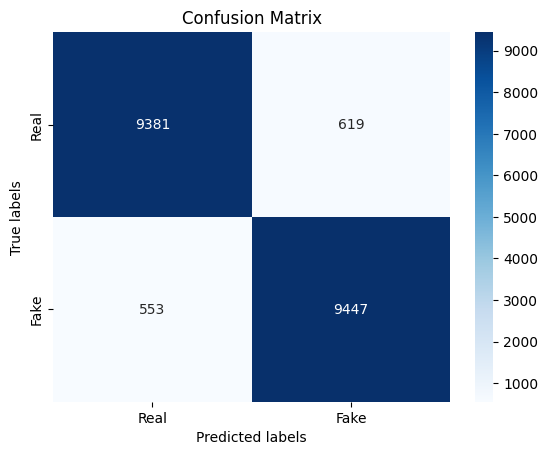

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For a nicer-looking confusion matrix

def plot_confusion_matrix(true_labels, predictions, class_names):
    # Generate the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Use seaborn to create a more visually appealing matrix
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming true_labels and test_predictions are already defined
class_names = ['Real', 'Fake']
plot_confusion_matrix(true_labels, test_predictions, class_names)
